In [1]:
import pyodbc
import pandas as pd
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=10.2.0.9, 1433;DATABASE=Finetrade.Replicated;UID=finetrade_replicated;PWD=C8jN4LrI')


In [2]:
query = """

declare @Ultimo as datetime = '20191201 00:01:00'

select 
	cast(o.TimeStamp as date)		'OrderDate',
	i.InvoiceNumberFull, i.Id		'InvoiceId',
	cast(i.SellDate as date)		'Sold to the bank',
	a.Name							'DistributorName',
	g.Description					'DistributorGroup',
	--o.CustomerId					'CustomerId',
	cast(i.InvoiceDate as date)		'InvoiceDate',
	concat(year(i.InvoiceDate)%100 , FORMAT(i.InvoiceDate,'MM')) InvPeriods,
	--'DUMMY'							'PaymentCompleted',
	p.Amount								'TotalPaid',
	--'DUMMY'							'Payment Date',
	coalesce(r.MaxReminder,0)		'ReminderLevel',
	e.Code							'WHG',
	i.OrderTotal					'Original Amount',
	case when cast(i.OrderTotal-coalesce(c.Amount,0) as money) < 0 then 0 else cast(i.OrderTotal-coalesce(c.Amount,0) as money)  end as  'Inv_netCN',																								
	case when cast(i.OrderTotal-coalesce(p.Amount,0)-coalesce(c.Amount,0)  as money) <0 then 0 else																								
		 cast(i.OrderTotal-coalesce(p.Amount,0)-coalesce(c.Amount,0)  as money) end as'OpenAmount_WOReminder',	
	--i.OrderTotal-coalesce(p.Amount,0)-coalesce(c.Amount,0) 'AmountTotal',
	--'DUMMY'							'AmountTotalLastMonth',
	coalesce(r2.ReminderAmount,0)	'RemindersAmount',
	coalesce(pa.PaidInk,0) 'RecoveredAmount',
	--'DUMMY'							'RemindersAmountLastMonth',
	--cast(h.AgreementDate as date)	'RemindersAgreementAmountDatum',
	i.TermOfPaymentDays				'Due Days',
	coalesce(r2.ReminderAmount,0)	'RemindersAgreementAmountNOW',
	coalesce(p.Amount,0)			'PaymentsAmount',
	co.taxrate 'Tax rate', --'DUMMY'	'PaymentsAmountLastMonth',
	coalesce(c.Amount,0)			'CreditsAmount',
	--case when ie.grundlagennummer is not null then 'YES' else 'NO' end ' InkassoEinstellung',
	--case when r.AgreementAmount is null then 'NO' else 'YES' end 'AgreementsYN',
	case when coalesce(Inkasso,0) = 0 then 'NO' else 'YES' end 'InkassoYN',
	cast(r.InkassoDate as date)		'InkassoTimestamp',
	concat(year(r.InkassoDate )%100 , FORMAT(r.InkassoDate ,'MM')) InkPeriods,																																											
	case when r.InkassoDate is null or  cast(i.OrderTotal-coalesce(p.Amount,0)-coalesce(c.Amount,0)  as money) < 0 																								
		then 0 else cast(i.OrderTotal-coalesce(p.Amount,0)-coalesce(c.Amount,0) as money) end as  'InkassoDueAmount_WOReminder',	
																																																
	case when r.InkassoDate is null or  cast(i.OrderTotal-coalesce(p.Amount,0)+coalesce(pa.PaidInk,0)-coalesce(c.Amount,0)	 as money) < 0 																								
		                    then 0 else cast(i.OrderTotal-coalesce(p.Amount,0)+coalesce(pa.PaidInk,0)-coalesce(c.Amount,0) as money) end as 'InkassoHandover_WOReminder'	,	

	y.Name							'PaymentMethods',
	--coalesce(p.CashBackFee,0)		'CashBackFee',
	coalesce(l.MaxInstallment,0)	'InstallmentsCount',
	n.ScoreValue					'ScoreValue',
	v.Percentage					'RatingPercentage',
	--b.Name							'CustomerName',
	b.Birthday						'Birthday',
	--u.Street						'Street',
	--u.City							'City',
	--u.Zip							'ZIP',
	w.Name							'Country',
    case when n.ScoreValue < '450' then '< 450' when n.ScoreValue between  '450' and '475' then '450-475' when n.ScoreValue between  '475' and '500' then '475-500'																								
	when n.ScoreValue between  '500' and '525' then '500-525' when n.ScoreValue between  '525' and '550' then '525-550' when n.ScoreValue between  '550' and '575' then '550-575'																								
	when n.ScoreValue between  '575' and '600' then '575-600' when n.ScoreValue between  '600' and '625' then '600-625' when n.ScoreValue between '625' and '650' then '625-650' 																								
	 when n.ScoreValue > '650' then '> 650' else 'NA' end as  ScoreGroup	
	 , Duedate = cast(i.InvoiceDate + i.TermOfPaymentDays as date)
	 , case when cast(i.InvoiceDate + i.TermOfPaymentDays as date) <= @Ultimo then 'Yes' else 'No' end as 'FlagDue'
	 , case when coalesce(Inkasso,0) = 0  and cast(i.InvoiceDate + i.TermOfPaymentDays + 60 as date) <= @Ultimo and cast(i.OrderTotal-coalesce(p.Amount,0)-coalesce(c.Amount,0) as money) > 0 then 1 else 0 end as Overaged
/* + INVOCES				*/ from Invoices i

/* - PAYMENTS				*/ left join (select InvoiceId, sum(Amount) Amount, sum(PaymentFee) CashBackFee from Payments where PaymentType = 0 and PaymentDate <= @Ultimo group by InvoiceId) p on p.InvoiceId = i.Id
/* - CREDIT NOTES			*/ left join (select InvoiceId, sum(Amount) Amount from Payments where PaymentType = 1 and PaymentDate <= @Ultimo group by InvoiceId) c on c.InvoiceId = i.Id
/* + REMINDERS - AGREEMENTS	*/ 
					left join (select InvoiceId, max(Id) ReminderId, sum(case when AgreementAmount is null then ReminderFee else AgreementAmount end) Amount, sum(ReminderFee) ReminderAmount, 
					sum(AgreementAmount) AgreementAmount, max(ReminderCount) MaxReminder, max(ExportedTimeStamp) InkassoDate, max(cast(Exported as varchar)) Inkasso 
					from Reminders group by InvoiceId) r on r.InvoiceId = i.Id
/* + REMINDERS - AGREEMENTS	*/
					left join (select InvoiceId, max(Id) ReminderId, sum(ReminderFee) ReminderAmount 					 
					from Reminders where timestamp < @Ultimo group by InvoiceId) r2 on r2.InvoiceId = i.Id 					 
		
					left join (select ReminderId, max(TimeStamp) AgreementDate from ReminderAgreementHistories 
					where TimeStamp < @Ultimo group by ReminderId) h on h.ReminderId = r.ReminderId
/* --- OrderDetails			*/ join CustomerOrders o on o.id = i.CustomerOrderId join Currencies e on e.Id = o.CurrencyId join PaymentOptions y on y.Id = o.PaymentOptionId 
left join (select InvoiceId, max(InstallmentNumber) MaxInstallment from Installments group by InvoiceId) l on l.InvoiceId = i.Id
/* --- ParnerDetails		*/ join Partners a on a.Id = o.DistributorId join Partners b on b.Id = o.CustomerId join Partners_Distributor d on d.Id = a.Id 
left join DistributorGroups g on d.DistributorGroupId = g.Id 
join (select PartnerId, Street, City, Zip, CountryId from Addresses where AddressTypeId = 1) u on u.PartnerId = b.Id 
join Countries w on w.Id = u.CountryId
/* --- ClientScores			*/ left join ClientScores n on n.ClientScoreId = o.ClientScoreId 
							left join RiskConversionRates v on v.RiskFinalValue = n.ScoreValue
/*----InkassoEinstellungen  */ --left join (select distinct(grundlagennummer) as grundlagennummer, max(Einstellungsdatum) as max_data from   [FineTrade.Reporting].dbo.InkassoEinstellungen group by Grundlagennummer)  ie on ie.Grundlagennummer=i.InvoiceNumberFull
/*-----CustomerOrders       */ left join Customerorders co on co.id=i.customerorderid 
                               left join ( select i.id, sum(p.Amount) as PaidInk from Invoices i join Payments p on p.InvoiceId = i.Id 	join Reminders r on r.InvoiceId = i.Id																								
				where  p.PaymentDate between r.ExportedTimeStamp and @Ultimo and PaymentType = 0 and r.ExportedTimeStamp is not null	group by i.Id) pa on pa.Id = i.Id	


where   i.FactoryBankId = 2 and i.InvoiceDate <= @Ultimo
  
  ---and (i.PaymentCompleted > @Ultimo or i.PaymentCompleted is null)  --i.OrderTotal-coalesce(p.Amount,0)-coalesce(c.Amount,0)+coalesce(r.Amount,0) >0 
--and y.Id in ( 4,5,9,12,14,16,17,19)
--i.SellDate <= @Ultimo and i.FactoryBankId = 2 and
--and  w.Name in ('Switzerland', 'Austria', 'Germany', 'Spain')  i.Sold = 0  and 
--is null --= 1 -- (i.PaymentCompleted > @Ultimo or i.PaymentCompleted is null) and
order by i.InvoiceDate asc

"""

In [3]:
data = pd.read_sql(query,conn)
print(data.head())

    OrderDate InvoiceNumberFull  InvoiceId Sold to the bank  \
0  2013-08-27       1342-337511     581029       2017-12-12   
1  2017-06-02       17OI-000409    3639858       2017-07-30   
2  2017-07-04       17OI-000411    3641170       2017-07-30   
3  2017-06-08       17OI-000410    3641169       2017-07-30   
4  2017-06-19       17OI-000414    3644127       2017-07-30   

                                     DistributorName DistributorGroup  \
0                                       MediaShop AG  Mediashop Group   
1                 Mineralölgroßhandlung Spiegel GmbH          Agility   
2                             Schrewe Vertriebs-GmbH          Agility   
3  Bischoff Vliex & Schöngen  PfenningsGmbH & Co. KG          Agility   
4                   Ilzhöfers Nachfolger  Inh. Walch          Agility   

  InvoiceDate InvPeriods  TotalPaid  ReminderLevel  ...   PaymentMethods  \
0  2013-08-26       1308      72.89              0  ...  Offene Rechnung   
1  2017-07-03       1707    10

In [4]:
data.to_excel(r"C:\NhanLeDocomoDigital\Automation\SQL\REB_Live_Pft_Data201911.xlsx") 

In [5]:
#data=pd.read_excel(r"C:\NhanLeDocomoDigital\Automation\SQL\REB_Live_Pft_Data.xlsx")

In [6]:
data.describe()

,InvoiceId,TotalPaid,ReminderLevel,Original Amount,Inv_netCN,OpenAmount_WOReminder,RemindersAmount,RecoveredAmount,Due Days,RemindersAgreementAmountNOW,PaymentsAmount,Tax rate,CreditsAmount,InkassoDueAmount_WOReminder,InkassoHandover_WOReminder,InstallmentsCount,RatingPercentage,Overaged
count,5.751220e+05,438563.000000,575122.000000,575122.000000,575122.000000,575122.000000,575122.000000,575122.000000,575122.000000,575122.000000,575122.000000,575122.000000,5.751220e+05,575122.000000,575122.000000,575122.000000,527958.000000,575122.000000
mean,4.611939e+06,91.930371,0.359432,101.533232,79.172397,10.727045,2.137793,3.296388,37.100820,2.137793,70.102099,19.138146,2.236851e+01,2.639023,5.434974,0.385657,0.032539,0.027916
std,2.111052e+05,228.339803,0.821406,330.391550,311.980815,170.120200,5.351884,42.923669,48.537364,5.351884,203.197369,1.130942,1.232211e+02,69.787214,85.618705,1.803996,0.045629,0.164732
min,5.810290e+05,-125.670000,0.000000,1.000000,0.000000,0.000000,0.000000,-849.220000,7.000000,0.000000,-125.670000,0.000000,-1.776357e-15,0.000000,0.000000,0.000000,0.000792,0.000000
25%,4.435045e+06,50.000000,0.000000,50.880000,15.940100,0.000000,0.000000,0.000000,30.000000,0.000000,11.190000,19.000000,0.000000e+00,0.000000,0.000000,0.000000,0.010392,0.000000
50%,4.606730e+06,60.880000,0.000000,60.880000,52.780000,0.000000,0.000000,0.000000,30.000000,0.000000,52.780000,19.000000,0.000000e+00,0.000000,0.000000,0.000000,0.016192,0.000000
75%,4.780749e+06,84.660000,0.000000,89.780000,74.670000,0.000000,0.000000,0.000000,30.000000,0.000000,74.900000,19.000000,0.000000e+00,0.000000,0.000000,0.000000,0.028832,0.000000
max,5.053116e+06,15254.340000,3.000000,22593.310000,22593.310000,11187.920000,162.000000,11121.350000,762.000000,162.000000,15254.340000,21.000000,1.159200e+04,10231.660000,11588.400000,24.000000,0.924456,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575122 entries, 0 to 575121
Data columns (total 36 columns):
OrderDate                      575122 non-null object
InvoiceNumberFull              575122 non-null object
InvoiceId                      575122 non-null int64
Sold to the bank               575122 non-null object
DistributorName                575122 non-null object
DistributorGroup               575122 non-null object
InvoiceDate                    575122 non-null object
InvPeriods                     575122 non-null object
TotalPaid                      438563 non-null float64
ReminderLevel                  575122 non-null int64
WHG                            575122 non-null object
Original Amount                575122 non-null float64
Inv_netCN                      575122 non-null float64
OpenAmount_WOReminder          575122 non-null float64
RemindersAmount                575122 non-null float64
RecoveredAmount                575122 non-null float64
Due Days             

In [8]:
#data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [9]:
pivotOverview = data.pivot_table(index=['InkassoYN', 'Overaged'], values=['InvoiceNumberFull','Inv_netCN',"OpenAmount_WOReminder","InkassoHandover_WOReminder", "InkassoDueAmount_WOReminder", "PaymentsAmount"], aggfunc={"InvoiceNumberFull":'count',"Inv_netCN":"sum","OpenAmount_WOReminder":'sum', "InkassoHandover_WOReminder":'sum', "InkassoDueAmount_WOReminder":'sum', "PaymentsAmount":'sum'},fill_value=0)
print(pivotOverview)

                    InkassoDueAmount_WOReminder  InkassoHandover_WOReminder  \
InkassoYN Overaged                                                            
NO        0                        0.000000e+00                0.000000e+00   
          1                        0.000000e+00                0.000000e+00   
YES       0                        1.517760e+06                3.125773e+06   

                       Inv_netCN  InvoiceNumberFull  OpenAmount_WOReminder  \
InkassoYN Overaged                                                           
NO        0         4.096157e+07             526620           4.645094e+06   
          1         9.238767e+05              16055           6.504943e+03   
YES       0         3.648345e+06              32447           1.517760e+06   

                    PaymentsAmount  
InkassoYN Overaged                  
NO        0           3.697184e+07  
          1           9.173717e+05  
YES       0           2.428045e+06  


In [10]:
pivotOverview.index

MultiIndex([( 'NO', 0),
            ( 'NO', 1),
            ('YES', 0)],
           names=['InkassoYN', 'Overaged'])

In [11]:
#https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html
idx = pd.IndexSlice
pivotOverview.loc[idx['NO', 1], idx['InvoiceNumberFull']]

16055.0

In [12]:
col_names1 =  ['Invoices', 'AmountNet_CN', 'Outstanding', 'Collection Rate']
index1 = ['Performing', "Collection", "Overaged" ]

In [13]:
df_overview  = pd.DataFrame(columns = col_names1, index = index1)

In [14]:
df_overview

,Invoices,AmountNet_CN,Outstanding,Collection Rate
Performing,NaN,NaN,NaN,NaN
Collection,NaN,NaN,NaN,NaN
Overaged,NaN,NaN,NaN,NaN


In [15]:
df_overview.index

Index(['Performing', 'Collection', 'Overaged'], dtype='object')

In [16]:
df_overview.loc['Performing',"Invoices"] = pivotOverview.loc[idx['NO', 0], idx['InvoiceNumberFull']]

In [17]:
df_overview

,Invoices,AmountNet_CN,Outstanding,Collection Rate
Performing,526620,NaN,NaN,NaN
Collection,NaN,NaN,NaN,NaN
Overaged,NaN,NaN,NaN,NaN


In [18]:
df_overview.loc['Performing',"AmountNet_CN"] = pivotOverview.loc[idx['NO', 0], idx['Inv_netCN']]

In [19]:
df_overview.loc['Performing',"Outstanding"] = pivotOverview.loc[idx['NO', 0], idx['OpenAmount_WOReminder']]

In [20]:
df_overview.loc['Performing',"Collection Rate"] = (df_overview.loc['Performing','AmountNet_CN']-df_overview.loc['Performing','Outstanding']) / df_overview.loc['Performing','AmountNet_CN'] 

In [21]:
df_overview

,Invoices,AmountNet_CN,Outstanding,Collection Rate
Performing,526620,4.09616e+07,4.64509e+06,0.886599
Collection,NaN,NaN,NaN,NaN
Overaged,NaN,NaN,NaN,NaN


In [22]:
df_overview.loc['Collection',"Invoices"] = pivotOverview.loc[idx['YES', 0], idx['InvoiceNumberFull']]
df_overview.loc['Collection',"AmountNet_CN"] = pivotOverview.loc[idx['YES', 0], idx['Inv_netCN']]
df_overview.loc['Collection',"Outstanding"] = pivotOverview.loc[idx['YES', 0], idx['OpenAmount_WOReminder']]
df_overview.loc['Collection',"Collection Rate"] = (df_overview.loc['Collection','AmountNet_CN']-df_overview.loc['Collection','Outstanding']) / df_overview.loc['Collection','AmountNet_CN'] 

In [23]:
df_overview

,Invoices,AmountNet_CN,Outstanding,Collection Rate
Performing,526620,4.09616e+07,4.64509e+06,0.886599
Collection,32447,3.64834e+06,1.51776e+06,0.583987
Overaged,NaN,NaN,NaN,NaN


In [24]:
df_overview.loc['Overaged',"Invoices"] = pivotOverview.loc[idx['NO', 1], idx['InvoiceNumberFull']]
df_overview.loc['Overaged',"AmountNet_CN"] = pivotOverview.loc[idx['NO', 1], idx['Inv_netCN']]
df_overview.loc['Overaged',"Outstanding"] = pivotOverview.loc[idx['NO', 1], idx['OpenAmount_WOReminder']]
df_overview.loc['Overaged',"Collection Rate"] = (df_overview.loc['Overaged','AmountNet_CN']-df_overview.loc['Overaged','Outstanding']) / df_overview.loc['Overaged','AmountNet_CN'] 

In [25]:
df_overview

,Invoices,AmountNet_CN,Outstanding,Collection Rate
Performing,526620,4.09616e+07,4.64509e+06,0.886599
Collection,32447,3.64834e+06,1.51776e+06,0.583987
Overaged,16055,923877,6504.94,0.992959


In [26]:
pivotMerchants = data.pivot_table(index=['DistributorGroup','InkassoYN', 'Overaged'], values=['InvoiceNumberFull','Inv_netCN',"OpenAmount_WOReminder","InkassoHandover_WOReminder", "InkassoDueAmount_WOReminder", "PaymentsAmount"], aggfunc={"InvoiceNumberFull":'count',"Inv_netCN":"sum","OpenAmount_WOReminder":'sum', "InkassoHandover_WOReminder":'sum', "InkassoDueAmount_WOReminder":'sum', "PaymentsAmount":'sum'},fill_value=0)
print(pivotMerchants)

                                     InkassoDueAmount_WOReminder  \
DistributorGroup InkassoYN Overaged                                
Agility          NO        0                              0.0000   
                           1                              0.0000   
                 YES       0                          88532.2891   
Loviit           NO        0                              0.0000   
                           1                              0.0000   
                 YES       0                         513007.4526   
MAPA Germany     NO        0                              0.0000   
                           1                              0.0000   
                 YES       0                          27677.9147   
Mediashop Group  NO        0                              0.0000   
                           1                              0.0000   
                 YES       0                         888542.4965   

                                     InkassoHan

In [27]:
pivotMerchants.loc[idx['Agility','NO', 0], idx['InvoiceNumberFull']]

1105.0

In [28]:
pivotMerchants.loc[idx['Agility','NO'], idx['InvoiceNumberFull']]

Overaged
0    1105
1     132
Name: InvoiceNumberFull, dtype: int64

In [29]:
pivotMerchants.loc[idx['Agility','NO'], idx['InvoiceNumberFull']].sum()

1237

In [30]:
pivotMerchants.loc[idx['Agility'], idx['InvoiceNumberFull']].sum()

1414

In [31]:
#pivotOverview.loc[idx['Agility','NO', 0], idx['OpenAmount_WOReminder']]

In [32]:
col_names2 =  ['Invoices', 'AmountNet_CN', 'Performing', 'Inkasso Handover',"Outst. in Debt Collection", "Overaged", "Handover Rate", "Collection Rate"]
index2 = ['Agility', "Chronext", "Watchmaster", "Mapa", "Mediashop", "Total Live Portfolio" ]

In [33]:
df_merchants  = pd.DataFrame(columns = col_names2, index = index2)

In [34]:
df_merchants.loc['Agility',"Invoices"] = pivotMerchants.loc[idx['Agility'], idx['InvoiceNumberFull']].sum()
df_merchants.loc['Agility',"AmountNet_CN"] = pivotMerchants.loc[idx['Agility'], idx['Inv_netCN']].sum()
df_merchants.loc['Agility',"Performing"] = pivotMerchants.loc[idx['Agility','NO', 0], idx['OpenAmount_WOReminder']]
df_merchants.loc['Agility',"Inkasso Handover"] = pivotMerchants.loc[idx['Agility','YES', 0], idx['InkassoHandover_WOReminder']]
df_merchants.loc['Agility',"Outst. in Debt Collection"] = pivotMerchants.loc[idx['Agility','YES', 0], idx['InkassoDueAmount_WOReminder']]
df_merchants.loc['Agility',"Overaged"] = pivotMerchants.loc[idx['Agility','NO', 1], idx['OpenAmount_WOReminder']]
df_merchants.loc['Agility',"Handover Rate"] = df_merchants.loc['Agility','Inkasso Handover']/ df_merchants.loc['Agility','AmountNet_CN'] 
df_merchants.loc['Agility',"Collection Rate"] = (df_merchants.loc['Agility','Inkasso Handover']-df_merchants.loc['Agility','Outst. in Debt Collection']) / df_merchants.loc['Agility','Inkasso Handover'] 
df_merchants

,Invoices,AmountNet_CN,Performing,Inkasso Handover,Outst. in Debt Collection,Overaged,Handover Rate,Collection Rate
Agility,1414,1.96482e+06,133577,154608,88532.3,0.2281,0.0786881,0.427375
Chronext,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Watchmaster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mapa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mediashop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Live Portfolio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df_merchants.loc['Mapa',"Invoices"] = pivotMerchants.loc[idx['MAPA Germany'], idx['InvoiceNumberFull']].sum()
df_merchants.loc['Mapa',"AmountNet_CN"] = pivotMerchants.loc[idx['MAPA Germany'], idx['Inv_netCN']].sum()
df_merchants.loc['Mapa',"Performing"] = pivotMerchants.loc[idx['MAPA Germany','NO', 0], idx['OpenAmount_WOReminder']]
df_merchants.loc['Mapa',"Inkasso Handover"] = pivotMerchants.loc[idx['MAPA Germany','YES', 0], idx['InkassoHandover_WOReminder']]
df_merchants.loc['Mapa',"Outst. in Debt Collection"] = pivotMerchants.loc[idx['MAPA Germany','YES', 0], idx['InkassoDueAmount_WOReminder']]
df_merchants.loc['Mapa',"Overaged"] = pivotMerchants.loc[idx['MAPA Germany','NO', 1], idx['OpenAmount_WOReminder']]
df_merchants.loc['Mapa',"Handover Rate"] = df_merchants.loc['Mapa','Inkasso Handover']/ df_merchants.loc['Mapa','AmountNet_CN'] 
df_merchants.loc['Mapa',"Collection Rate"] = (df_merchants.loc['Mapa','Inkasso Handover']-df_merchants.loc['Mapa','Outst. in Debt Collection']) / df_merchants.loc['Mapa','Inkasso Handover'] 
df_merchants

,Invoices,AmountNet_CN,Performing,Inkasso Handover,Outst. in Debt Collection,Overaged,Handover Rate,Collection Rate
Agility,1414,1.96482e+06,133577,154608,88532.3,0.2281,0.0786881,0.427375
Chronext,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Watchmaster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mapa,46283,1.05993e+06,28473.1,57160.4,27677.9,221.053,0.0539284,0.515785
Mediashop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Live Portfolio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_merchants.loc['Mediashop',"Invoices"] = pivotMerchants.loc[idx['Mediashop Group'], idx['InvoiceNumberFull']].sum()
df_merchants.loc['Mediashop',"AmountNet_CN"] = pivotMerchants.loc[idx['Mediashop Group'], idx['Inv_netCN']].sum()
df_merchants.loc['Mediashop',"Performing"] = pivotMerchants.loc[idx['Mediashop Group','NO', 0], idx['OpenAmount_WOReminder']]
df_merchants.loc['Mediashop',"Inkasso Handover"] = pivotMerchants.loc[idx['Mediashop Group','YES', 0], idx['InkassoHandover_WOReminder']]
df_merchants.loc['Mediashop',"Outst. in Debt Collection"] = pivotMerchants.loc[idx['Mediashop Group','YES', 0], idx['InkassoDueAmount_WOReminder']]
df_merchants.loc['Mediashop',"Overaged"] = pivotMerchants.loc[idx['Mediashop Group','NO', 1], idx['OpenAmount_WOReminder']]
df_merchants.loc['Mediashop',"Handover Rate"] = df_merchants.loc['Mediashop','Inkasso Handover']/ df_merchants.loc['Mediashop','AmountNet_CN'] 
df_merchants.loc['Mediashop',"Collection Rate"] = (df_merchants.loc['Mediashop','Inkasso Handover']-df_merchants.loc['Mediashop','Outst. in Debt Collection']) / df_merchants.loc['Mediashop','Inkasso Handover'] 
df_merchants

,Invoices,AmountNet_CN,Performing,Inkasso Handover,Outst. in Debt Collection,Overaged,Handover Rate,Collection Rate
Agility,1414,1.96482e+06,133577,154608,88532.3,0.2281,0.0786881,0.427375
Chronext,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Watchmaster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mapa,46283,1.05993e+06,28473.1,57160.4,27677.9,221.053,0.0539284,0.515785
Mediashop,524556,3.30932e+07,600247,2.22487e+06,888542,6283.65,0.0672303,0.600631
Total Live Portfolio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
pivotMerchants2 = data.pivot_table(index=['DistributorName','InkassoYN', 'Overaged'], values=['InvoiceNumberFull','Inv_netCN',"OpenAmount_WOReminder","InkassoHandover_WOReminder", "InkassoDueAmount_WOReminder", "PaymentsAmount"], aggfunc={"InvoiceNumberFull":'count',"Inv_netCN":"sum","OpenAmount_WOReminder":'sum', "InkassoHandover_WOReminder":'sum', "InkassoDueAmount_WOReminder":'sum', "PaymentsAmount":'sum'},fill_value=0)
print(pivotMerchants2)

                                                                       InkassoDueAmount_WOReminder  \
DistributorName                                    InkassoYN Overaged                                
A. Adam GmbH                                       NO        0                              0.0000   
                                                             1                              0.0000   
A. Gaiser Mineralöl Vertriebs-GmbH                 NO        0                              0.0000   
                                                             1                              0.0000   
                                                   YES       0                           1860.0002   
...                                                                                            ...   
Wojciechowski Transport - Logistik - Vertriebs ... NO        0                              0.0000   
Yalcin & Tiebes GmbH                               NO        0                    

In [38]:
df_merchants.loc['Chronext',"Invoices"] = pivotMerchants2.loc[idx['Chronext Service Germany GmbH'], idx['InvoiceNumberFull']].sum()
df_merchants.loc['Chronext',"AmountNet_CN"] = pivotMerchants2.loc[idx['Chronext Service Germany GmbH'], idx['Inv_netCN']].sum()
df_merchants.loc['Chronext',"Performing"] = pivotMerchants2.loc[idx['Chronext Service Germany GmbH','NO', 0], idx['OpenAmount_WOReminder']]
df_merchants.loc['Chronext',"Inkasso Handover"] = pivotMerchants2.loc[idx['Chronext Service Germany GmbH','YES', 0], idx['InkassoHandover_WOReminder']]
df_merchants.loc['Chronext',"Outst. in Debt Collection"] = pivotMerchants2.loc[idx['Chronext Service Germany GmbH','YES', 0], idx['InkassoDueAmount_WOReminder']]
df_merchants.loc['Chronext',"Overaged"] = pivotMerchants2.loc[idx['Chronext Service Germany GmbH','NO', 1], idx['OpenAmount_WOReminder']]
df_merchants.loc['Chronext',"Handover Rate"] = df_merchants.loc['Chronext','Inkasso Handover']/ df_merchants.loc['Chronext','AmountNet_CN'] 
df_merchants.loc['Chronext',"Collection Rate"] = (df_merchants.loc['Chronext','Inkasso Handover']-df_merchants.loc['Chronext','Outst. in Debt Collection']) / df_merchants.loc['Chronext','Inkasso Handover'] 
df_merchants

,Invoices,AmountNet_CN,Performing,Inkasso Handover,Outst. in Debt Collection,Overaged,Handover Rate,Collection Rate
Agility,1414,1.96482e+06,133577,154608,88532.3,0.2281,0.0786881,0.427375
Chronext,2526,7.92137e+06,3.25383e+06,639803,472391,0.0121,0.0807692,0.261661
Watchmaster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mapa,46283,1.05993e+06,28473.1,57160.4,27677.9,221.053,0.0539284,0.515785
Mediashop,524556,3.30932e+07,600247,2.22487e+06,888542,6283.65,0.0672303,0.600631
Total Live Portfolio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_merchants.loc['Watchmaster',"Invoices"] = pivotMerchants2.loc[idx['Watchmaster ICP GmbH'], idx['InvoiceNumberFull']].sum()
df_merchants.loc['Watchmaster',"AmountNet_CN"] = pivotMerchants2.loc[idx['Watchmaster ICP GmbH'], idx['Inv_netCN']].sum()
df_merchants.loc['Watchmaster',"Performing"] = pivotMerchants2.loc[idx['Watchmaster ICP GmbH','NO', 0], idx['OpenAmount_WOReminder']]
df_merchants.loc['Watchmaster',"Inkasso Handover"] = pivotMerchants2.loc[idx['Watchmaster ICP GmbH','YES', 0], idx['InkassoHandover_WOReminder']]
df_merchants.loc['Watchmaster',"Outst. in Debt Collection"] = pivotMerchants2.loc[idx['Watchmaster ICP GmbH','YES', 0], idx['InkassoDueAmount_WOReminder']]
df_merchants.loc['Watchmaster',"Overaged"] = pivotMerchants2.loc[idx['Watchmaster ICP GmbH','NO', 1], idx['OpenAmount_WOReminder']]
df_merchants.loc['Watchmaster',"Handover Rate"] = df_merchants.loc['Watchmaster','Inkasso Handover']/ df_merchants.loc['Watchmaster','AmountNet_CN'] 
df_merchants.loc['Watchmaster',"Collection Rate"] = (df_merchants.loc['Watchmaster','Inkasso Handover']-df_merchants.loc['Watchmaster','Outst. in Debt Collection']) / df_merchants.loc['Watchmaster','Inkasso Handover'] 
df_merchants

,Invoices,AmountNet_CN,Performing,Inkasso Handover,Outst. in Debt Collection,Overaged,Handover Rate,Collection Rate
Agility,1414,1.96482e+06,133577,154608,88532.3,0.2281,0.0786881,0.427375
Chronext,2526,7.92137e+06,3.25383e+06,639803,472391,0.0121,0.0807692,0.261661
Watchmaster,341,1.4883e+06,623465,49335.6,40616.2,0.001,0.033149,0.176736
Mapa,46283,1.05993e+06,28473.1,57160.4,27677.9,221.053,0.0539284,0.515785
Mediashop,524556,3.30932e+07,600247,2.22487e+06,888542,6283.65,0.0672303,0.600631
Total Live Portfolio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
x = df_merchants["Invoices"].sum()
x

575120

In [41]:
df_merchants

,Invoices,AmountNet_CN,Performing,Inkasso Handover,Outst. in Debt Collection,Overaged,Handover Rate,Collection Rate
Agility,1414,1.96482e+06,133577,154608,88532.3,0.2281,0.0786881,0.427375
Chronext,2526,7.92137e+06,3.25383e+06,639803,472391,0.0121,0.0807692,0.261661
Watchmaster,341,1.4883e+06,623465,49335.6,40616.2,0.001,0.033149,0.176736
Mapa,46283,1.05993e+06,28473.1,57160.4,27677.9,221.053,0.0539284,0.515785
Mediashop,524556,3.30932e+07,600247,2.22487e+06,888542,6283.65,0.0672303,0.600631
Total Live Portfolio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_merchants.loc['Total Live Portfolio',"AmountNet_CN"] = df_merchants["AmountNet_CN"].sum()
df_merchants.loc['Total Live Portfolio',"Performing"] = df_merchants["Performing"].sum()
df_merchants.loc['Total Live Portfolio',"Inkasso Handover"] = df_merchants["Inkasso Handover"].sum()
df_merchants.loc['Total Live Portfolio',"Outst. in Debt Collection"] = df_merchants["Outst. in Debt Collection"].sum()
df_merchants.loc['Total Live Portfolio',"Overaged"] = df_merchants["Overaged"].sum()
df_merchants.loc['Total Live Portfolio',"Handover Rate"] = df_merchants.loc['Total Live Portfolio','Inkasso Handover']/ df_merchants.loc['Total Live Portfolio','AmountNet_CN'] 
df_merchants.loc['Total Live Portfolio',"Collection Rate"] = (df_merchants.loc['Total Live Portfolio','Inkasso Handover']-df_merchants.loc['Total Live Portfolio','Outst. in Debt Collection']) / df_merchants.loc['Total Live Portfolio','Inkasso Handover']
df_merchants

,Invoices,AmountNet_CN,Performing,Inkasso Handover,Outst. in Debt Collection,Overaged,Handover Rate,Collection Rate
Agility,1414,1.96482e+06,133577,154608,88532.3,0.2281,0.0786881,0.427375
Chronext,2526,7.92137e+06,3.25383e+06,639803,472391,0.0121,0.0807692,0.261661
Watchmaster,341,1.4883e+06,623465,49335.6,40616.2,0.001,0.033149,0.176736
Mapa,46283,1.05993e+06,28473.1,57160.4,27677.9,221.053,0.0539284,0.515785
Mediashop,524556,3.30932e+07,600247,2.22487e+06,888542,6283.65,0.0672303,0.600631
Total Live Portfolio,NaN,4.55276e+07,4.63959e+06,3.12577e+06,1.51776e+06,6504.94,0.0686566,0.514437


In [44]:
data=pd.read_excel(r"C:\NhanLeDocomoDigital\Automation\REB report\Capital Employed 201911.xlsx", index_col="Date")

In [45]:
data

,Installments,Open Invoices,Total,Bank Fee,Captial Employed,Unnamed: 6,Unnamed: 7,Unnamed: 8
Date,,,,,,,,
2019-11-01,5409299,702831,6112130,46041.410700,6.066089e+06,NaN,NaN,NaN
2019-10-01,5731277,743181,6474458,54497.730000,6.419960e+06,NaN,NaN,NaN
2019-09-01,5704913,701131,6406044,45345.000000,6.360699e+06,NaN,NaN,NaN
2019-08-19,5830123,718097,6548220,53104.680000,6.495115e+06,NaN,NaN,NaN
2019-07-01,5865545,726586,6592131,71407.590000,6.520723e+06,NaN,Avg 6M Campital Employed,6.392539e+06
2019-06-01,5797824,752376,6550200,57550.200000,6.492650e+06,NaN,NaN,NaN
2019-05-01,5753766,761858,6515624,53870.260000,6.461754e+06,NaN,NaN,NaN
2019-04-01,5874556,768560,6643116,56859.770000,6.586256e+06,NaN,NaN,NaN
2019-03-01,5965577,791488,6757065,71207.410000,6.685858e+06,NaN,NaN,NaN


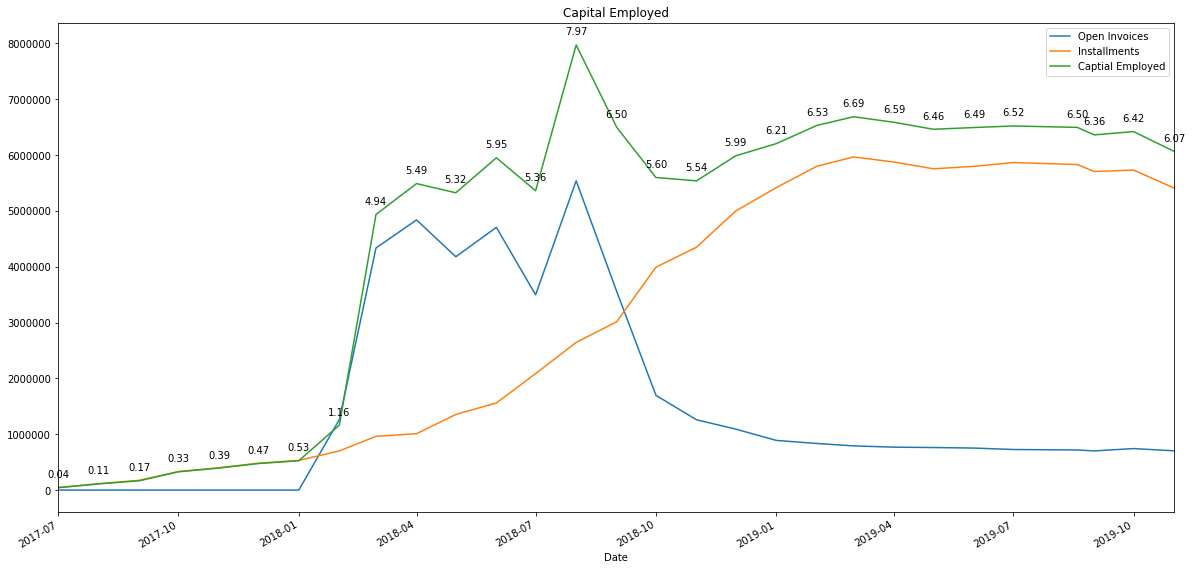

In [47]:
import matplotlib.pyplot as plt
xs = data.index.values
ys = data["Captial Employed"].values
lines = data[["Open Invoices", "Installments", "Captial Employed"]].plot.line(figsize = (20,10), title = "Capital Employed", legend = True )


for x,y in zip(xs,ys):

    label = "{:.2f}".format(y/1000000)

    lines.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

lines

In [49]:
lines.figure.savefig(r"C:\NhanLeDocomoDigital\Automation\REB report\capitalEmployed_Graph.png")

In [50]:
with pd.ExcelWriter(r"C:\NhanLeDocomoDigital\Automation\REB report\REB live Pft 201911.xlsx") as writer:  # doctest: +SKIP
    df_overview.to_excel(writer, sheet_name='overview')
    df_merchants.to_excel(writer, sheet_name='merchants')

In [51]:
from openpyxl import load_workbook
import openpyxl
#create workbook object
wb = load_workbook(r"C:\NhanLeDocomoDigital\Automation\REB report\REB live Pft 201911.xlsx")
ws = wb.active
img = openpyxl.drawing.image.Image(r"C:\NhanLeDocomoDigital\Automation\REB report\capitalEmployed_Graph.png")
#ws.add_image(ws.cell(row=1, column=1))
ws.add_image(img, 'B9')
wb.save(r"C:\NhanLeDocomoDigital\Automation\REB report\REB live Pft 201911.xlsx")                  